In [1]:
using AutoRisk
using AutoViz
using Distributions
using HDF5
using PGFPlots

In [15]:
function visualize_scenario(rec::SceneRecord, roadway::Roadway)
    @manipulate for veh_id in collect(1:length(rec.scenes[1])),
                zoom in [10.],
                i in 1:(rec.nscenes)
        idx = -(rec.nscenes - i)
        stats = [CarFollowingStatsOverlay(veh_id, 2), NeighborsOverlay(veh_id, textparams = TextParams(x = 600, y_start=300))]
        cam = CarFollowCamera(veh_id, zoom)
        render(get_scene(rec, idx), roadway, stats, cam = cam)
    end
end

visualize_scenario (generic function with 2 methods)

In [17]:
function build_debug_collector(num_scenarios::Int = 1, num_runs::Int = 1)
    # build evaluator
    ext = MultiFeatureExtractor(AbstractFeatureExtractor[CarLidarFeatureExtractor()])
    context = IntegratedContinuous(.1, 1)
    num_veh = 2
    prime_time = .1
    sampling_time = .1
    sampling_period = .1
    veh_idx_can_change = false
    num_scenes = Int(ceil((prime_time + sampling_time) / sampling_period)) + 1
    num_features = length(ext)
    num_targets = 5
    rec = SceneRecord(num_scenes, .1, num_veh)
    features = Array{Float64}(num_features, 1, num_veh)
    targets = Array{Float64}(num_targets, num_veh)
    agg_targets = Array{Float64}(num_targets, num_veh)
    eval = MonteCarloEvaluator(ext, num_runs, context, prime_time, sampling_time,
            veh_idx_can_change, rec, features, targets, agg_targets)

    # build collector
    seeds = collect(1:num_scenarios)
    roadwaygen = StaticRoadwayGenerator(gen_straight_roadway(1))
    scenegen = DebugSceneGenerator()
    behgen = DebugBehaviorGenerator()
    max_num_samples = num_veh * num_scenarios 
    dataset = Dataset("/Users/wulfebw/Desktop/test.h5", num_features, 1, num_targets, max_num_samples, init_file = false, chunk_dim=10)
    scene = Scene(num_veh)
    models = Dict{Int, DriverModel}()
    roadway = rand!(roadwaygen, 1)
    col = DatasetCollector(seeds, roadwaygen, scenegen, behgen, eval, dataset, scene, models, roadway)
    return col
end

build_debug_collector (generic function with 3 methods)

In [18]:
col = build_debug_collector();

In [19]:
rand!(col, 2)

Dict{Int64,AutomotiveDrivingModels.DriverModel} with 2 entries:
  2 => AutomotiveDrivingModels.Tim2DDriver(SceneRecord(nscenes=0),AutomotiveDri…
  1 => AutomotiveDrivingModels.Tim2DDriver(SceneRecord(nscenes=0),AutomotiveDri…

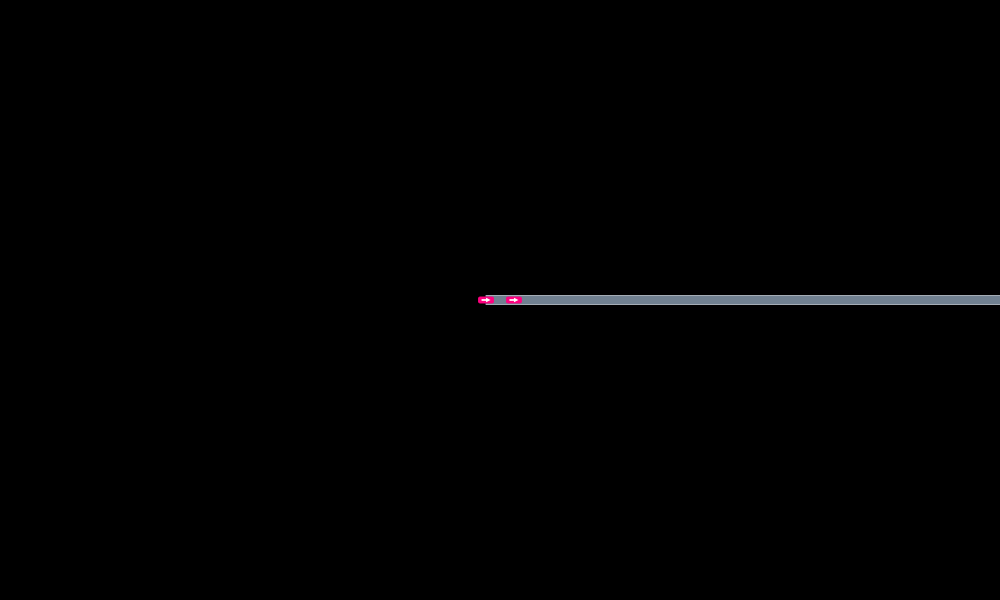

In [20]:
render(col.scene, col.roadway)

In [21]:
evaluate!(col.eval, col.scene, col.models, col.roadway, 1)

10-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"veh_id",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2),Dict(2=>"2",1=>"1")),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(10.0, nactions=1),"zoom",10.0,"10.0",Interact.OptionDict(DataStructures.OrderedDict("10.0"=>10.0),Dict(10.0=>"10.0")),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(1, nactions=1),"i",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2),Dict(2=>"2",1=>"1")),Any[],Any[],true,"horizontal")

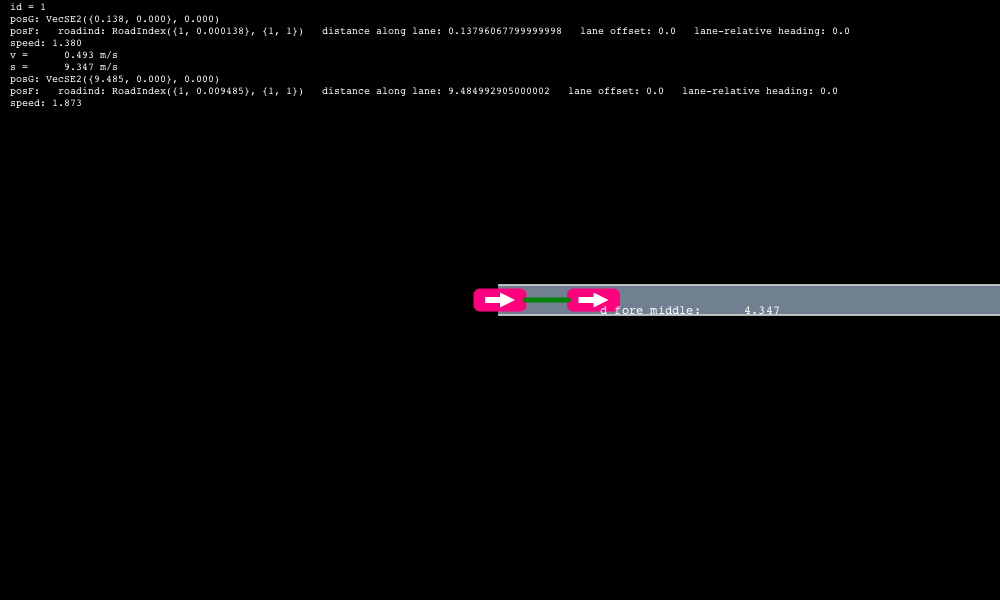

In [22]:
visualize_scenario(col.eval.rec, col.roadway)